В этом проекте я занималась обучением Byte-level BPE токенизатора и небольшой LM.  

Проект состоит из нескольких последовательных блоков:
1. реализация и обучение токенизатора,
2. реализация Transformer модели,
3. обучение модели на датасете с русскими анекдотами

In [ ]:
%pip install --quiet datasets livelossplot

In [ ]:
import inspect
import json
import os
import math
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

In [ ]:
interpreter_login()

In [ ]:
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/nlp_hehehe"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

Homework repository: 'shikhmin/nlp_hehehe'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [ ]:
dataset = load_dataset("json", data_files="hf://datasets/IgorVolochay/russian_jokes/dataset.json")
print("\n===\n".join(dataset["train"]["jokes"][:3]))

- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!
 
===
После проведения акции "К животным по-человечески" животные посовещались
 и решили провести акцию "К человеку по-скотски".
 
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.
 


In [ ]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset

DatasetDict({
    train: Dataset({
        features: ['jokes'],
        num_rows: 135497
    })
    test: Dataset({
        features: ['jokes'],
        num_rows: 15056
    })
})

# Токенизатор

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [ ]:
# regular expression for tokenization
WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

In [ ]:
def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [ ]:
def merge(merge_pair: tuple[str, str],
          pair_frequences: Counter[tuple[str, str]],
          words_by_tokens: Counter[tuple[str]]):
    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """
    a, b = merge_pair
    new_token = a + b

    new_token_count = Counter()

    for word, freq in words_by_tokens.items():
      i = 0
      merge = []
      while i < len(word):
        if i < len(word) -1 and word[i] == a and word[i + 1] == b:
          merge.append(new_token)
          i +=2
        else:
          merge.append(word[i])
          i+=1
      new_token_count[tuple(merge)] +=freq

    new_pair_freq = Counter()

    for word, freq in new_token_count.items():
      for i in range(len(word) - 1):
        pair = [word[i], word[i+1]]
        new_pair_freq[tuple(pair)] += freq
    return new_token_count, new_pair_freq



In [ ]:
def merge(merge_pair: tuple[str, str],
          pair_frequences: Counter[tuple[str, str]],
          words_by_tokens: Counter[tuple[str]]):

    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """

    a, b = merge_pair
    new_token = a + b

    delta_words = Counter()   # word -> +/- freq

    for word, freq in list(words_by_tokens.items()):
        has_pair = False
        for i in range(len(word)-1):
          if word[i] == a and word[i+1] == b:
            has_pair = True
            break
        if not has_pair:
            continue

        for i in range((len(word) - 1)):
          pair_frequences[(word[i], word[i+1])] -= freq

        new_word_list = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and word[i] == a and word[i+1] == b:
                new_word_list.append(new_token)
                i += 2
            else:
                new_word_list.append(word[i])
                i += 1
        new_word = tuple(new_word_list)

        for i in range((len(new_word) - 1)):
          pair_frequences[(new_word[i], new_word[i+1])] += freq

        delta_words[word] -= freq
        delta_words[new_word] += freq

    words_by_tokens.update(delta_words)

    for i in (list(words_by_tokens.keys())):
       if words_by_tokens[i] <= 0:
        del words_by_tokens[i]

    for i in (list(pair_frequences.keys())):
       if pair_frequences[i] <= 0:
        del pair_frequences[i]

    return pair_frequences, words_by_tokens


In [ ]:
def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data

    Args:
        data: List of train documents
        vocab_size: Size of target vocabulary
        special_tokens: List of special tokens to add into vocabulary
    Returns:
        vocabulary: mapping from string token to id
        merges: list of merges, each one is tuple of string tokens
    """
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    id2token = bytes_to_unicode()
    merges = []

    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            word_byte = word.encode('utf-8')
            if not word_byte:
              continue
            tokens = tuple(id2token[b] for b in word_byte)
            words_by_tokens[tokens] += 1

    pair_frequences = Counter()

    for word, freq in list(words_by_tokens.items()):
        for i in range(len(word)-1):
          pair_frequences[(word[i], word[i+1])] += freq


    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        top_pair = max(pair_frequences, key=pair_frequences.get)
        new_token = top_pair[0] + top_pair[1]
        del pair_frequences[top_pair]

        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [ ]:
# Обучаем токенизатор на тренировочных текстах

vocab, merges = train(dataset["train"]["jokes"], vocab_size=1024, special_tokens=["[EOS]"])

Loading data:   0%|          | 0/135497 [00:00<?, ?it/s]

Building vocabulary:  25%|##5       | 257/1024 [00:00<?, ?it/s]

In [ ]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

Token #512: 'ус'
Token #614: ' Э'
Token #768: 'уз'
Token #888: ' после'
Token #1022: 'ались'


In [ ]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        # The closer the pair is to the beginning, the higher the rank
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        """Process word into tokenized representation.
        Word is a tuple of base tokens, i.e. bytes.

        Under the hood:
        1. Tracks the set of token pairs, bi-grams
        2. While possible, replaces the highest-ranking pair with its union

        Args:
            word: list of base string tokens
        Return:
            list of BPE tokens
        """
        if len(word) < 2:
          return word
        pairs = {(word[i], word[i+1]) for i in range (len(word) -1)}

        while True:
          best_rank = None
          best_pair = None
          for pair in pairs:
            rank = self.bpe_ranks.get(pair)
            if rank is not None and (best_rank is None or rank < best_rank):
              best_pair = pair
              best_rank = rank

          if best_pair is None:
            break

          fir, sec = best_pair
          new_word_list = []
          i = 0
          while i < len(word):
            if i < len(word) - 1 and word[i] == fir and word[i+1] == sec:
              new_word_list.append(fir + sec)
              i +=2
            else:
              new_word_list.append(word[i])
              i +=1

          word = tuple(new_word_list)
          if len(word) < 2:
            break
          else:
            pairs = {(word[i], word[i+1]) for i in range (len(word) -1)}

        return word


    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        """Convert string to list of token ids.

        Args:
            text: input string, may contain multiple words
            add_eos_token: whether to add eos token id at the end
        Return:
            list of ints, ids of tokenized text
        """
        words = WHITESPACE_SPLITTER.findall(text)
        ids = []
        for w in words:
          enc_w = w.encode('utf-8')
          if not enc_w:
            continue

          base_token = tuple(self.byte_encoder[b] for b in enc_w)
          bpe_token = self.bpe(base_token)
          for t in bpe_token:
            tok_id = self.token2id.get(t)
            if tok_id is None:
              for ch in t:
                ids.append(self.token2id[self.byte_encoder[self.byte_decoder[ch]]])
            else:
              ids.append(tok_id)
        if add_eos_token:
          ids.append(self.eos_token_id)
        return ids


    def decode(self, idx: list[int]) -> str:
        """Convert list of tokens' ids to text, opposite to encode method

        Args:
            idx: list of tokens' ids
        Return:
            string, decoded text
        """
        if idx and idx[-1] == self.eos_token_id:
          ids = idx[:-1]
        else:
          ids = idx

        dec_str = ''
        dec_str_l = []
        for id in ids:
          str_token = self.id2token[id]
          dec_str_l.append(str_token)
        dec_str = ''.join(dec_str_l)

        text_str = bytes(self.byte_decoder[i] for i in dec_str)
        dec_w = text_str.decode('utf-8', errors='replace')

        return dec_w


    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [ ]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [ ]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/shikhmin/nlp_hehehe/commit/ad3b13c34101c28d2148f2cc2526df163f5353d0', commit_message='Upload folder using huggingface_hub', commit_description='', oid='ad3b13c34101c28d2148f2cc2526df163f5353d0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shikhmin/nlp_hehehe', endpoint='https://huggingface.co', repo_type='model', repo_id='shikhmin/nlp_hehehe'), pr_revision=None, pr_num=None)

In [ ]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Смотрим на работу токенизатора

text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[777, 282, 755, 482, 350, 304, 258, 1020, 358, 63, 357, 301, 361, 257, 330, 616, 767, 419, 633, 657, 781, 405, 44, 482, 350, 304, 258, 1020, 358, 398, 360, 339, 336, 863, 277, 323, 316, 338, 272, 380, 345, 316, 372, 502, 349, 279, 350, 391, 264, 259, 46, 1023]
Ч|то| было| пол|г|од|а| наз|ад|?| П|ом|им|о| г|ран|ди|оз|ных| соб|ыт|ий|,| пол|г|од|а| наз|ад| бы|ли| е|щ|ё| с|ем|ин|ар|ы| по| л|ин|ей|ной| а|л|г|еб|р|е|.|
Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре.


In [ ]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["jokes"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

  0%|          | 0/15056 [00:00<?, ?it/s]

Average token len per sample: 73.49
Minimum and maximum lens are: 5 and 3418


# Модель

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [ ]:
# конфиг для модели
@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
}

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        rms = (self.eps + torch.mean(x**2, dim=-1, keepdim=True))**0.5
        norm_x = x/rms * self.scale

        return norm_x

In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and ALiBi for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

        # Init projection layers
        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.n_head * self.head_dim, bias = False)
        self.kv_proj = nn.Linear(self.config.hidden_dim, 2 * self.config.n_kv_head * self.head_dim, bias = False)
        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias = False)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))
        self.register_buffer("alibi", self._build_alibi_bias(self.config.n_head))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        """Build ALiBi for specified number of heads:

        Returns:
            Tensor with ALiBi biases, shape: [1, num heads, 1, 1]
        """
        n = 2 ** math.floor(math.log2(num_heads))
        m_0 = 2.0 ** (-8.0 / n)
        m = torch.pow(m_0, torch.arange(1, 1 + n))
        if n < num_heads:
          m_0_hat = 2.0 ** (-4.0 / n) #тут мб косяк
          m_hat = torch.pow(m_0_hat, torch.arange(1, 1 + 2 * (num_heads - n), 2))
          m = torch.cat([m, m_hat])

        return m.view(1, num_heads, 1, 1)


    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        t = torch.ones((max_seq_len, max_seq_len))
        t = torch.tril(t, diagonal = 0)
        reshaped_t = torch.reshape(t, (1, 1, max_seq_len, max_seq_len))
        res_tb = reshaped_t.to(dtype=torch.bool)

        return res_tb

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        q = self.q_proj(x)
        kv = self.kv_proj(x)
        k, v = torch.split(kv, self.config.n_kv_head * self.head_dim, dim=2)

        bs = x.size(0)
        seq_len = x.size(1)

        q = q.view([bs, seq_len, self.config.n_head, self.head_dim])
        q = torch.transpose(q, 1, 2)
        k = k.view([bs, seq_len, self.config.n_kv_head, self.head_dim])
        k = torch.transpose(k, 1, 2)
        v = v.view([bs, seq_len, self.config.n_kv_head, self.head_dim])
        v = torch.transpose(v, 1, 2)

        if self.config.n_kv_head != self.config.n_head:
            k = k.repeat_interleave(self.q_per_kv, dim=1)
            v = v.repeat_interleave(self.q_per_kv, dim=1)

        att_scores = (q @ k.transpose(-2, -1)) * self.scale

        positions = torch.arange(seq_len, device=x.device)
        rel_pos = positions.view(1, 1, seq_len, 1) - positions.view(1, 1, 1, seq_len)
        rel_pos = rel_pos.clamp(min=0)
        alibi_bias = self.alibi * rel_pos
        att_scores = att_scores - alibi_bias

        causal = self.causal_mask[:, :, :seq_len, :seq_len]
        att_scores = att_scores.masked_fill(~causal, float("-inf"))

        if attention_mask is not None:
            if attention_mask.dim() == 3:
                attention_mask = attention_mask.squeeze(-1)
            key_mask = attention_mask[:, None, None, :].bool()
            att_scores = att_scores.masked_fill(~key_mask, float("-inf"))

        att_weights = F.softmax(att_scores, dim=-1)
        att_weights = self.attn_dropout(att_weights)

        out = torch.matmul(att_weights, v)
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, self.config.hidden_dim)
        out = self.out_proj(out)
        return out

In [ ]:
class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        # Init up- and down- projection layers
        self.fc1 = nn.Linear(self.config.hidden_dim, 2 * self.config.intermediate_dim, bias=False)
        self.fc2 = nn.Linear(self.config.intermediate_dim, self.config.hidden_dim, bias = False)

    def forward(self, x: Tensor) -> Tensor:
        """Apply SwiGLU to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x1 = self.fc1(x)
        gate, value = torch.split(x1, self.config.intermediate_dim, dim=-1)

        y = F.silu(gate) * value
        data = self.fc2(y)
        return data

In [ ]:
class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_norm = self.ln_1(x)
        self_att = self.attn(x_norm, attention_mask)
        x = x + self.res_dropout_1(self_att)

        x_norm2 = self.ln_2(x)
        swig = self.mlp(x_norm2)
        x = x + self.res_dropout_2(swig)

        return x

In [ ]:
class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(self.vocab_size, self.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(self.hidden_dim, self.vocab_size, bias = False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _save_pretrained(self, save_directory: str):
      os.makedirs(save_directory, exist_ok=True)
      model_path = os.path.join(save_directory, "pytorch_model.bin")
      torch.save(self.state_dict(), model_path)

    @classmethod
    def _from_pretrained(cls, resolved_archive_file, *model_args, config=None, **kwargs):
        model = cls(config, *model_args, **kwargs)
        state_dict = torch.load(resolved_archive_file, map_location="cpu")
        model.load_state_dict(state_dict)
        return model

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        x = self.token_emb(input_ids)
        x = self.emb_dropout(x)
        for block in self.layers:
            x = block(x, attention_mask=attention_mask)
        x = self.ln_final(x)
        logits = self.lm_head(x)

        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            logits = logits[:, -1, :] / max(temperature, 1e-10)

            if top_k is not None:
                vals, _ = torch.topk(logits, top_k, dim = -1)
                thresh = vals[..., -1, None]
                mask = logits < thresh
                logits[mask] = -float("inf")

            probs = F.softmax(logits, dim = -1)

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples = 1)
            else:
                _, idx_next = torch.max(probs, dim = -1, keepdim = True)

            idx = torch.cat((idx, idx_next), dim=1)
            if (idx_next == eos_token_id).all():
                break
        return idx

# Train Loop

In [ ]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длинного семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 726,  347,  281,   33, 1023, 1023, 1023, 1023],
        [ 526,  303, 1009,  261,  576,  258,   63, 1023]])

tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 488,  294,  298,  644,  827,  263,  323,  276,  323,  531,  692,  596,
          880, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [ ]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Scheduler for Optimizer with linear warmup and linear decay to the end of training

    Args:
        optimizer: torch optimizer to control learning rate
        num_warmup_steps: number of warmup steps
        num_training_steps: total number of training steps
    Return:
        torch learning rate scheduler
    """
    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
          return float(current_step) / float(max(1, num_warmup_steps))
        return max(0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    """Calculate Cross-Entropy loss for Language Modeling task
    Under the hood:
    1. Create targets based on input ids
    2. Masked out tokens corresponded to paddings
    3. Calculate cross entropy loss

    Args:
        input_ids: tensor with input ids, shape [bs, seq len]
        attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        logits: predicted logits, shape [bs, seq len, vocab size]
    Return:
        cross entropy loss, single-item tensor
    """
    sh_logs = logits[:, :-1, :].contiguous()
    sh_label = input_ids[:, 1:].contiguous()
    sh_mask = attention_mask[:, 1:].contiguous()

    voc_size = sh_logs.size(-1)
    loss = F.cross_entropy(sh_logs.view(-1, voc_size),
                           sh_label.view(-1),
                           reduction = 'none')
    loss = loss * sh_mask.view(-1)

    den = sh_mask.sum().clamp_min(1.0)
    loss = loss.sum() / den
    return loss

In [ ]:
# Определим тренера с наиболее важными гиперпараметрами для обучения

class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=10_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [ ]:
# Создаем тренировочный и тестовые даталоадеры

MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["jokes"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["jokes"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [ ]:
# Инициализируем модель

config = model_configs["nano"]
model = TransformerForCausalLM(config)

Number of parameters: 0.50M


In [ ]:
# Инициализируем тренера

trainer = Trainer(learning_rate=3e-4)

running on device cpu


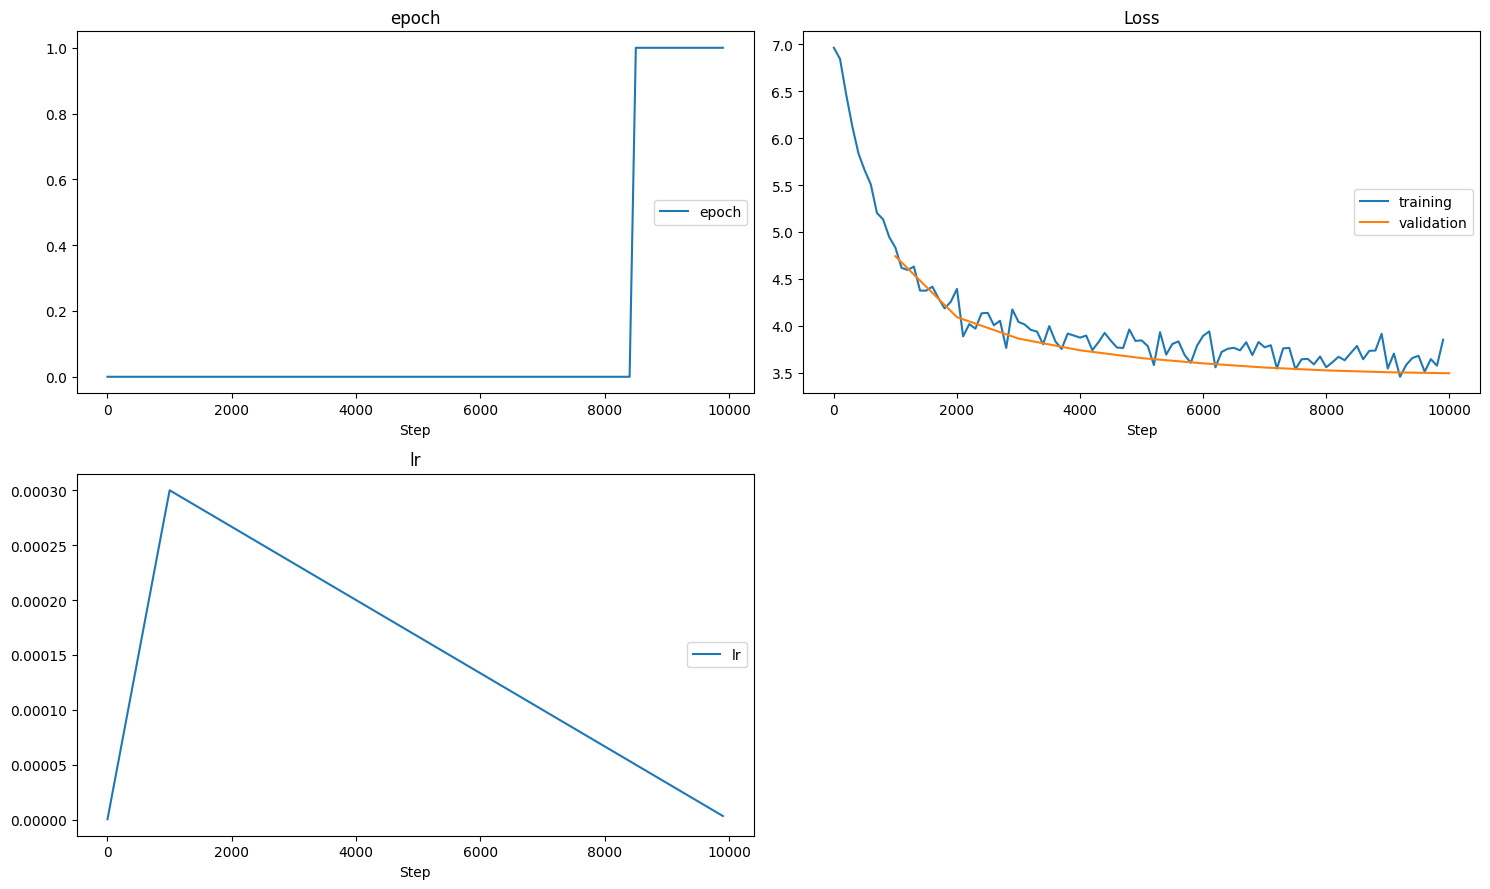

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    3.458, max:    6.962, cur:    3.853)
	validation       	 (min:    3.495, max:    4.742, cur:    3.495)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [ ]:
# Обучение goes brrrr!

trainer.run(model, train_dataloader, test_dataloader)

In [ ]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

tensor([[717, 258, 618, 275, 302, 338]])


'Заходит в бар, что на улице. А ведь я на ну сножку, и товарищ.\n- А я, ты, что, наверные.\n- Второй разрешает, как у вас в театри достают.\n- Слушай!\n- Я же ты, вчера у меня нет! Вчера я на медведь в боюшкой 50, пятно!\n- Не сынивай, а как у тебя вечер. \n- Да, это с ними побой. \n- Вовочка.\n- Я бы ты далеко-то я съифону. \n- Вдруг у меня ведь яйцу я сняться, и немного.\n- Мужик, я сегодня сразу, а точно,'

In [ ]:
for prompt in [
    "Встречаются программист и математик",
    "Студент МФТИ на экзамене",
    "Сколько сантехников нужно",
    "Штирлиц услышал"
]:
    input_ids = torch.tensor(tokenizer.encode(prompt)[:-1], device=trainer.device)[None, :]
    output = model.generate(
        input_ids, max_new_tokens=1000, eos_token_id=tokenizer.eos_token_id,
        do_sample=True, top_k=20, temperature=0.7   #0.7
    )
    print(f"\nPROMPT: {prompt}\n---\n{tokenizer.decode(output[0].tolist())}\n")


PROMPT: Встречаются программист и математик
---
Встречаются программист и математике. Из-потиво, утром поставление, а вместо не приходится на стране.
 


PROMPT: Студент МФТИ на экзамене
---
Студент МФТИ на экзамене играть, если я не подумали, что мышел, то он не у него.
 


PROMPT: Сколько сантехников нужно
---
Сколько сантехников нужно обненного бутылку: "Слажи! Мама, а ведь не ведьмножно не достает!".
 


PROMPT: Штирлиц услышал
---
Штирлиц услышал музыками и бегать.
 



In [ ]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._hehehe/pytorch_model.bin:  26%|##6       |  538kB / 2.07MB            

CommitInfo(commit_url='https://huggingface.co/shikhmin/nlp_hehehe/commit/ab8ef54470d8dac1c7c89331118ad045e413af13', commit_message='Push model using huggingface_hub.', commit_description='', oid='ab8ef54470d8dac1c7c89331118ad045e413af13', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shikhmin/nlp_hehehe', endpoint='https://huggingface.co', repo_type='model', repo_id='shikhmin/nlp_hehehe'), pr_revision=None, pr_num=None)